Compute and plot IDF curves on one Gridpoint: 

1. For each Duration 
    A. Compute rolling sum of rain
    B. Determine threshold (minimum of annual maximums)
    C. Identify all precip > threshold in rolling sum & compute exceedances
    D. Fit GPD (Generalized Pareto Distribution) to exceedances
    E. Estimate Parameters Sigma (scale) and Xi (shape)
    F. Validate Fitted distribution  
    G. Use GPD return level formula to get return period values
2. Plot IDF

In [63]:
# Choose duration (minutes)
choose_duration_idx = 6

durations = [10, 30, 60, 360, 720, 1080, 1440]
durations_labels = ['10MIN', '30MIN', '1H', '6H', '12H', '18H', '24H']

duration = durations[choose_duration_idx]
duration_label = durations_labels[choose_duration_idx]

In [64]:
# Load packages & data
import joblib
import xarray as xr
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import genextreme as gev
import lmoments3 as lm3
import lmoments3.distr as ldist 
rainfall_data = joblib.load('rainfall_data_2011_2020_835x_520y.pkl') #10min rain


A. Compute rolling sum

In [65]:
window = int(duration/durations[0])
print('Duration selected:', duration_label)
#rain_roll_sum = rainfall_data.rolling(time=window, center=False).sum()
rain_roll_sum = rainfall_data.resample(time='1D').sum()

Duration selected: 24H


In [66]:
rain_roll_sum.max()

<xarray.DataArray 'RAIN' ()>
array(224.39175, dtype=float32)

B. Determine threshold (minimum of annual maximums) 

In [67]:
annual_max = rain_roll_sum.resample(time="1Y").max()
threshold = min(annual_max.values)
print('Threshold:', threshold)

Threshold: 105.30184


C. Identify all precip > threshold in rolling sum & compute exceedances (+ print number of POT)

In [68]:
rain_over_threshold = rain_roll_sum.where(rain_roll_sum >= threshold, drop=True)
print(f'There are {len(rain_over_threshold)} POT in 2011-2020 (rain over {threshold:.2f} mm in {duration_label} rolling cumul) ')
exceedances = rain_over_threshold - threshold


There are 32 POT in 2011-2020 (rain over 105.30 mm in 24H rolling cumul) 


D. Fit GPD (Generalized Pareto Distribution) to exceedances


GPD Fit Parameters: Shape (ξ) = 0.0302, Scale (σ) = 26.4375, Location (μ) = 0


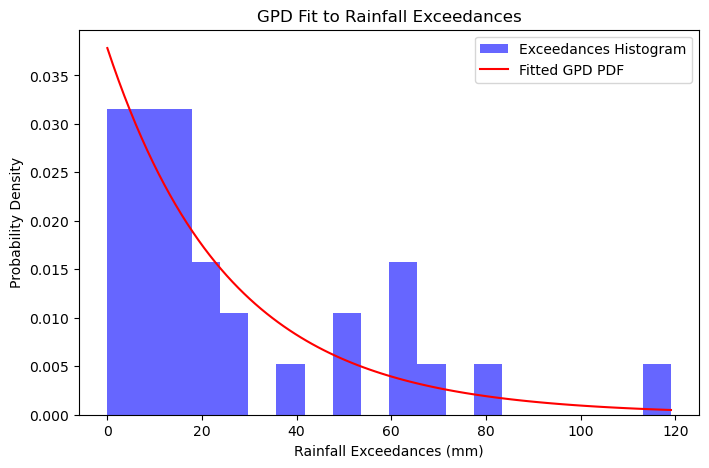

In [69]:

shape, loc, scale = stats.genpareto.fit(exceedances.values, floc=0)
print(f"GPD Fit Parameters: Shape (ξ) = {shape:.4f}, Scale (σ) = {scale:.4f}, Location (μ) = {loc}")

# Plot Histogram vs GPD PDF
x = np.linspace(min(exceedances), max(exceedances), 100)
pdf = stats.genpareto.pdf(x, shape, loc=loc, scale=scale)

plt.figure(figsize=(8, 5))
plt.hist(exceedances, bins=20, density=True, alpha=0.6, color="blue", label="Exceedances Histogram")
plt.plot(x, pdf, 'r-', label="Fitted GPD PDF")
plt.xlabel("Rainfall Exceedances (mm)")
plt.ylabel("Probability Density")
plt.title("GPD Fit to Rainfall Exceedances")
plt.legend()
plt.show()


F. Validate Fitted distribution  

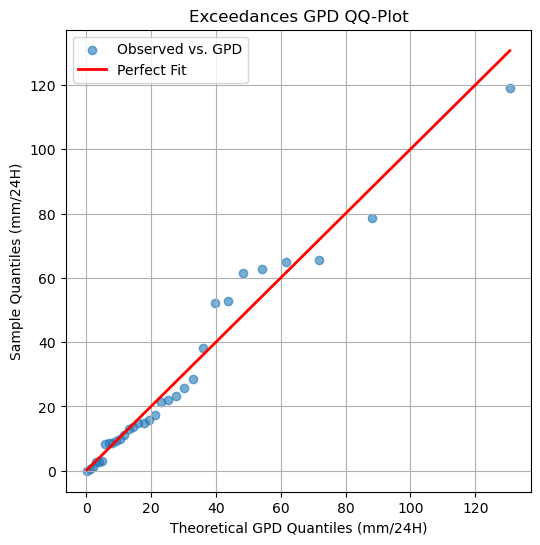

In [70]:
#QQ-Plots : Compare Data vd theoretical GPD (Generalized Pareto Distribution)

# Compute empirical and theoretical quantiles
quantiles = np.linspace(0.01, 0.99, len(exceedances)) #Here quantiles are probabilities values
empirical = np.sort(exceedances) #Values observed of exceedances over threshold
theoretical = stats.genpareto.ppf(quantiles, shape, loc=0, scale=scale) #Using Gen pareto distribution parameters, return value of exceedance expected for given probabilities

# Plot QQ-Plot
plt.figure(figsize=(6, 6))
plt.scatter(theoretical, empirical, label="Observed vs. GPD", alpha=0.6)
plt.plot(theoretical, theoretical, 'r-', label="Perfect Fit", linewidth=2)
plt.xlabel(f"Theoretical GPD Quantiles (mm/{duration_label})")
plt.ylabel(f"Sample Quantiles (mm/{duration_label})")
plt.title("Exceedances GPD QQ-Plot")
plt.legend()
plt.grid()
plt.show()



D.2. Fit distribution to GEV using L-moments


In [80]:
lmom = lm3.lmom_ratios(rain_over_threshold, nmom=5)
print("Sample L-moments (L-moment ratios):")
print(lmom)
gev_params = ldist.gev.lmom_fit(rain_over_threshold)
print("\nFitted GEV parameters using L-moments:")
print(gev_params)
shape, loc, scale = gev_params['c'], gev_params['loc'], gev_params['scale']
l = loc + scale / shape
print(shape, loc, scale)

Sample L-moments (L-moment ratios):
[132.55848789215088, 14.642591507204116, 0.35941789046183337, 0.14909107998588716, 0.03328303812186331]

Fitted GEV parameters using L-moments:
OrderedDict([('c', -0.27509808235099525), ('loc', 118.16256634602631), ('scale', 15.214399010927496)])
-0.27509808235099525 118.16256634602631 15.214399010927496


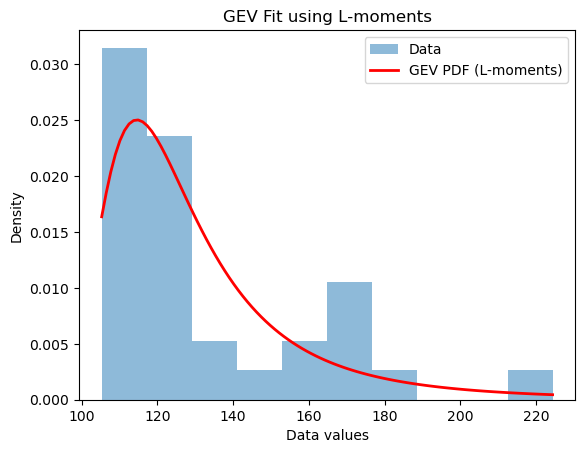

In [ ]:
#PLOTTING
# xx = np.linspace(l+0.00001, l+0.00001+100, num=71)
# yy = gev.pdf(xx, shape, loc, scale)
# hist, bins = np.histogram(data, bins=100, range=(0, 200), density=True)
# plt.bar(bins[:-1], hist, width = 2, align='edge')
# plt.plot(xx, yy, 'ro')
# plt.show()

x = np.linspace(l+0.00001, l+0.00001+100, num=100)
#x = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = ldist.gev.pdf(x, **gev_params)
plt.hist(rain_over_threshold, bins=10, density=True, alpha=0.5, label="Data")
plt.plot(x, pdf_gev, 'r-', lw=2, label="GEV PDF (L-moments)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using L-moments")
plt.legend()
plt.show()

In [73]:
data = rain_over_threshold
shape, loc, scale = gev.fit(data)
l = loc + scale / shape
print(l)
print(shape, loc, scale)

94.03702037627019
-0.5475146283634681 116.64296648227787 12.377086181035382


In [74]:
rain_over_threshold


<xarray.DataArray 'RAIN' (time: 32)>
array([157.93942 , 183.96738 , 115.14703 , 105.89679 , 118.95806 ,
       114.6545  , 133.81479 , 114.0518  , 127.238686, 108.072624,
       108.029175, 128.65353 , 166.94545 , 167.9771  , 130.89536 ,
       126.617905, 122.50569 , 116.33276 , 113.655266, 170.36414 ,
       106.57732 , 120.167694, 118.37179 , 121.15611 , 113.993385,
       224.39175 , 120.205475, 157.3133  , 170.92496 , 108.18483 ,
       143.5657  , 105.30184 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-25 2012-11-04 ... 2020-05-11
Attributes:
    standard_name:  Accumulated rainfall
    long_name:      Accumulated rainfall
    units:          mm

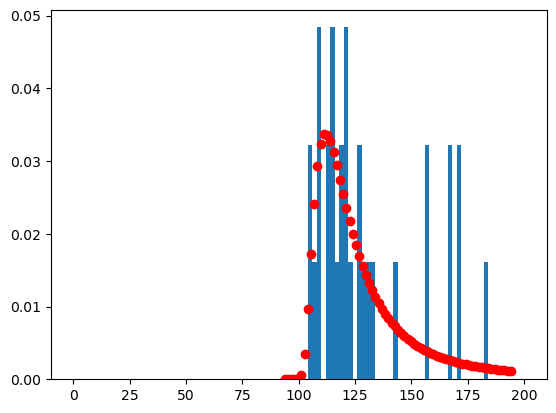

In [75]:
xx = np.linspace(l+0.00001, l+0.00001+100, num=71)
yy = gev.pdf(xx, shape, loc, scale)
hist, bins = np.histogram(data, bins=100, range=(0, 200), density=True)
plt.bar(bins[:-1], hist, width = 2, align='edge')

plt.plot(xx, yy, 'ro')
plt.show()

In [76]:
'''
# Bootstrap settings
n_bootstrap = 1000  # Number of bootstrap samples
bootstrap_params = []

for _ in range(n_bootstrap):
    resampled_exceedances = np.random.choice(exceedances, size=len(exceedances), replace=True)
    shape_bs, loc_bs, scale_bs = stats.genpareto.fit(resampled_exceedances)
    bootstrap_params.append((shape_bs, loc_bs, scale_bs))

# Convert to NumPy array for percentile calculations
bootstrap_params = np.array(bootstrap_params)

# Compute 95% Confidence Intervals
shape_ci = np.percentile(bootstrap_params[:, 0], [2.5, 97.5])
scale_ci = np.percentile(bootstrap_params[:, 2], [2.5, 97.5])

print(f"GPD Shape (ξ) CI: {shape_ci}")
print(f"GPD Scale (σ) CI: {scale_ci}")
'''

'\n# Bootstrap settings\nn_bootstrap = 1000  # Number of bootstrap samples\nbootstrap_params = []\n\nfor _ in range(n_bootstrap):\n    resampled_exceedances = np.random.choice(exceedances, size=len(exceedances), replace=True)\n    shape_bs, loc_bs, scale_bs = stats.genpareto.fit(resampled_exceedances)\n    bootstrap_params.append((shape_bs, loc_bs, scale_bs))\n\n# Convert to NumPy array for percentile calculations\nbootstrap_params = np.array(bootstrap_params)\n\n# Compute 95% Confidence Intervals\nshape_ci = np.percentile(bootstrap_params[:, 0], [2.5, 97.5])\nscale_ci = np.percentile(bootstrap_params[:, 2], [2.5, 97.5])\n\nprint(f"GPD Shape (ξ) CI: {shape_ci}")\nprint(f"GPD Scale (σ) CI: {scale_ci}")\n'

In [77]:
'''
ks_stat, p_value = stats.kstest(exceedances, "genpareto", args=(shape, loc, scale))
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
'''


'\nks_stat, p_value = stats.kstest(exceedances, "genpareto", args=(shape, loc, scale))\nprint(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")\n'

In [78]:
#return levels plots with bootstraping error

'''import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define return periods (years)
return_periods = np.array([2, 5, 10, 20, 50, 100])

# Extract exceedances (values above threshold)
#exceedances = rain_roll_sum.where(rain_roll_sum > threshold, drop=True).values

# Fit GPD with fixed location at threshold
shape, loc, scale = stats.genpareto.fit(exceedances)

# Compute exceedance rate (λ_u)
n_exceedances = len(exceedances)
total_years = 10
λ_u = n_exceedances / total_years  # Exceedances per year

# Compute return levels
return_levels = threshold + (scale / shape) * ((λ_u * return_periods) ** shape - 1)

# ---- BOOTSTRAPPING FOR UNCERTAINTY ---- #
n_bootstrap = 1000
bootstrap_return_levels = np.zeros((n_bootstrap, len(return_periods)))

for i in range(n_bootstrap):
    resampled_exceedances = np.random.choice(exceedances, size=n_exceedances, replace=True)
    shape_bs, loc, scale_bs = stats.genpareto.fit(resampled_exceedances)
    bootstrap_return_levels[i, :] = threshold + (scale_bs / shape_bs) * ((λ_u * return_periods) ** shape_bs - 1)

# Compute 95% confidence intervals
return_level_ci_lower = np.percentile(bootstrap_return_levels, 2.5, axis=0)
return_level_ci_upper = np.percentile(bootstrap_return_levels, 97.5, axis=0)

# ---- PLOT RETURN LEVELS WITH BOOTSTRAP ERROR BANDS ---- #
plt.figure(figsize=(8, 5))

# Plot main return level curve
plt.plot(return_periods, return_levels, marker='o', linestyle='-', color='b', label="Fitted GPD")

# Add bootstrap confidence intervals as dashed lines
plt.plot(return_periods, return_level_ci_lower, 'r--', label="95% CI (Lower)")
plt.plot(return_periods, return_level_ci_upper, 'r--', label="95% CI (Upper)")

# Labels and log-scale
plt.xlabel("Return Period (years)")
plt.ylabel(f"Return Level (mm/{duration_label})")
plt.title("Return Level Plot with 95% Confidence Intervals")
#plt.xscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()
'''

'import numpy as np\nimport scipy.stats as stats\nimport matplotlib.pyplot as plt\n\n# Define return periods (years)\nreturn_periods = np.array([2, 5, 10, 20, 50, 100])\n\n# Extract exceedances (values above threshold)\n#exceedances = rain_roll_sum.where(rain_roll_sum > threshold, drop=True).values\n\n# Fit GPD with fixed location at threshold\nshape, loc, scale = stats.genpareto.fit(exceedances)\n\n# Compute exceedance rate (λ_u)\nn_exceedances = len(exceedances)\ntotal_years = 10\nλ_u = n_exceedances / total_years  # Exceedances per year\n\n# Compute return levels\nreturn_levels = threshold + (scale / shape) * ((λ_u * return_periods) ** shape - 1)\n\n# ---- BOOTSTRAPPING FOR UNCERTAINTY ---- #\nn_bootstrap = 1000\nbootstrap_return_levels = np.zeros((n_bootstrap, len(return_periods)))\n\nfor i in range(n_bootstrap):\n    resampled_exceedances = np.random.choice(exceedances, size=n_exceedances, replace=True)\n    shape_bs, loc, scale_bs = stats.genpareto.fit(resampled_exceedances)\n   

In [79]:
'''#Monte Carlo

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define return periods (years)
return_periods = np.array([2, 5, 10, 20, 50, 100])


# Extract exceedances (values above threshold)
# exceedances = rain_roll_sum.where(rain_roll_sum > threshold, drop=True).values  # Uncomment for real data

# Fit GPD with fixed location at threshold
shape, loc, scale = stats.genpareto.fit(exceedances.values)

# Compute exceedance rate (λ_u)
n_exceedances = len(exceedances)
total_years = 10  # Adjust based on data
λ_u = n_exceedances / total_years  # Exceedances per year

# Compute return levels
return_levels = threshold + (scale / shape) * ((λ_u * return_periods) ** shape - 1)

# ---- MONTE CARLO SIMULATION FOR UNCERTAINTY ---- #
n_mc = 1000  # Number of Monte Carlo simulations
mc_return_levels = np.zeros((n_mc, len(return_periods)))

for i in range(n_mc):
    # Simulate new exceedances from the fitted GPD
    simulated_exceedances = stats.genpareto.rvs(shape, loc, scale, size=n_exceedances)

    # Refit GPD to simulated data
    shape_mc, loc, scale_mc = stats.genpareto.fit(simulated_exceedances)

    # Compute Monte Carlo return levels
    mc_return_levels[i, :] = threshold + (scale_mc / shape_mc) * ((λ_u * return_periods) ** shape_mc - 1)

# Compute 95% confidence intervals
return_level_ci_lower = np.percentile(mc_return_levels, 2.5, axis=0)
return_level_ci_upper = np.percentile(mc_return_levels, 97.5, axis=0)

# ---- PLOT RETURN LEVELS WITH MONTE CARLO ERROR BANDS ---- #
plt.figure(figsize=(8, 5))

# Plot main return level curve
plt.plot(return_periods, return_levels, marker='o', linestyle='-', color='b', label="Fitted GPD")

# Add Monte Carlo confidence intervals as dashed lines
plt.plot(return_periods, return_level_ci_lower, 'r--', label="95% CI (Lower)")
plt.plot(return_periods, return_level_ci_upper, 'r--', label="95% CI (Upper)")

# Labels and log-scale
plt.xlabel("Return Period (years)")
plt.ylabel("Return Level (mm)")
plt.title("Return Level Plot with Monte Carlo 95% Confidence Intervals")
#plt.xscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()
'''


'#Monte Carlo\n\nimport numpy as np\nimport scipy.stats as stats\nimport matplotlib.pyplot as plt\n\n# Define return periods (years)\nreturn_periods = np.array([2, 5, 10, 20, 50, 100])\n\n\n# Extract exceedances (values above threshold)\n# exceedances = rain_roll_sum.where(rain_roll_sum > threshold, drop=True).values  # Uncomment for real data\n\n# Fit GPD with fixed location at threshold\nshape, loc, scale = stats.genpareto.fit(exceedances.values)\n\n# Compute exceedance rate (λ_u)\nn_exceedances = len(exceedances)\ntotal_years = 10  # Adjust based on data\nλ_u = n_exceedances / total_years  # Exceedances per year\n\n# Compute return levels\nreturn_levels = threshold + (scale / shape) * ((λ_u * return_periods) ** shape - 1)\n\n# ---- MONTE CARLO SIMULATION FOR UNCERTAINTY ---- #\nn_mc = 1000  # Number of Monte Carlo simulations\nmc_return_levels = np.zeros((n_mc, len(return_periods)))\n\nfor i in range(n_mc):\n    # Simulate new exceedances from the fitted GPD\n    simulated_exceedanc